### Transfer Learning over InceptionV3 and Image Dataset Augmentation

Previous example: [/examples/keras_applications/intermediate_layers.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/keras_applications/intermediate_layers.ipynb)  
Modified from: [keras.io/api/applications/](https://keras.io/api/applications/)  
Next example: [/examples/nlp/intro.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/nlp/intro.ipynb)

In [1]:
import sys
sys.path.insert(0, '../../') # To be able to reach 'datasets' folder
from pathlib import Path
from IPython.display import Image, display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, clone_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

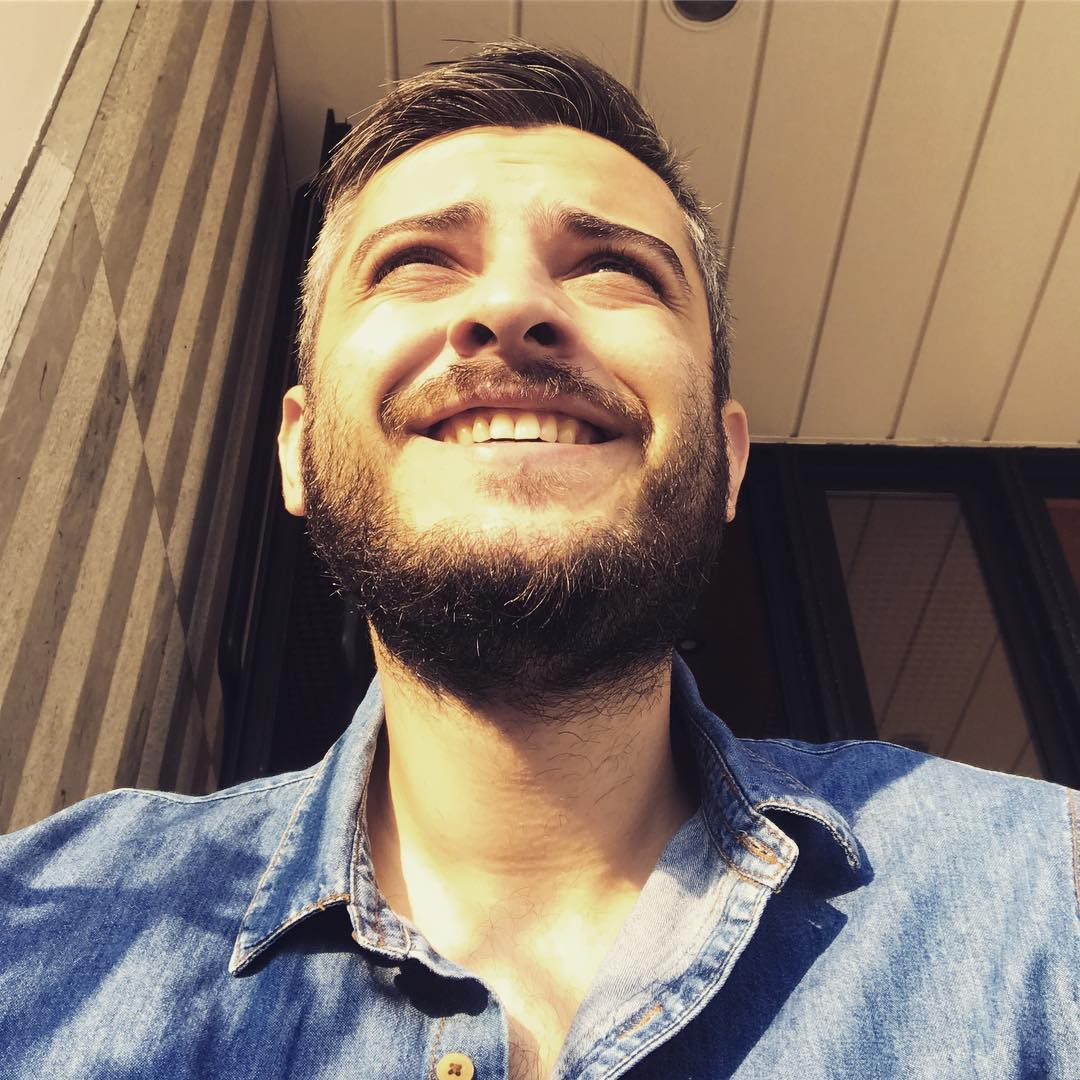

X_train                  : (105, 224, 224, 3)
y_train                  : (105, 7)
y_train_argmax           : (105,)
X_test                   : (35, 224, 224, 3)
y_test                   : (35, 7)
y_test_argmax            : (35,)


In [2]:
dataset_path = Path.cwd().parent.parent / 'datasets' / 'people'
data = []
target = []
num_of_people = 7
num_of_images = 20
for person_idx in range(num_of_people):
    for image_idx in range(num_of_images):
        img_path = dataset_path / f'{person_idx}' / f'{image_idx}.jpg'
        if person_idx == 0 and image_idx == 0: display(Image(img_path, width=300))
        array_image = img_to_array(load_img(img_path, target_size=(224, 224)))
        expanded_image = np.expand_dims(array_image, axis=0)
        processed_image = preprocess_input(expanded_image)
        data.append(processed_image)
        target.append(person_idx)

del dataset_path, num_of_images, person_idx, image_idx, img_path, array_image, expanded_image, processed_image
data = np.vstack(data)
target = np.vstack(target)
target = np_utils.to_categorical(target)
X_train, X_test, y_train, y_test = train_test_split(data, target)
del data, target
data_gen = ImageDataGenerator(rotation_range=25, width_shift_range=0.25, height_shift_range=0.25, \
    horizontal_flip=True, validation_split=0.25)

data_gen.fit(X_train) 
y_train_argmax = np.argmax(y_train, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
def print_data(msg, data): print(f'{msg:25}: {data.shape}')
print_data('X_train', X_train)
print_data('y_train', y_train)
print_data('y_train_argmax', y_train_argmax)
print_data('X_test', X_test)
print_data('y_test', y_test)
print_data('y_test_argmax', y_test_argmax)

In [3]:
def disp_results(func, gt, pred, msg): print(f'{func.__name__} of {msg}:\n{func(gt, pred)}')
def analyse(y_train_argmax, y_train_pred, y_test_argmax, y_test_pred):
    disp_results(classification_report, y_train_argmax, y_train_pred, 'training data')
    disp_results(confusion_matrix, y_train_argmax, y_train_pred, 'training data')
    print()
    disp_results(classification_report, y_test_argmax, y_test_pred, 'test data')
    disp_results(confusion_matrix, y_test_argmax, y_test_pred, 'test data')

In [4]:
epoch_num = 64
batch_size = 8
base_model = InceptionV3(weights='imagenet', include_top=False)
layer = base_model.output
layer = GlobalAveragePooling2D()(layer)
layer = Dropout(.1)(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(.2)(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(.8)(layer)
layer = Dense(128, activation='relu')(layer)
out = Dense(num_of_people, activation='softmax')(layer)
del num_of_people
full_model = Model(inputs=base_model.input, outputs=out)
for layer in base_model.layers: layer.trainable = False
full_model_copy = clone_model(full_model)
full_model_copy.set_weights(full_model.get_weights()) 
full_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
full_model_copy.compile(optimizer='rmsprop', loss='categorical_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
print('Before Training Phase 1 - Version 1:')
analyse(y_train_argmax, np.argmax(full_model.predict(X_train, verbose=0), axis=1), \
    y_test_argmax, np.argmax(full_model.predict(X_test, verbose=0), axis=1))

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-22 22:18:50.852680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-22 22:18:50.852787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Before Training Phase 1 - Version 1:


2022-12-22 22:18:53.693254: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-22 22:18:54.032208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


classification_report of training data:
              precision    recall  f1-score   support

           0       0.24      0.53      0.33        15
           1       0.00      0.00      0.00        16
           2       0.07      0.13      0.09        15
           3       0.11      0.24      0.15        17
           4       0.14      0.06      0.09        16
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        16

    accuracy                           0.14       105
   macro avg       0.08      0.14      0.09       105
weighted avg       0.08      0.14      0.10       105

confusion_matrix of training data:
[[8 0 4 3 0 0 0]
 [3 0 4 7 2 0 0]
 [3 0 2 9 1 0 0]
 [6 0 5 4 2 0 0]
 [4 0 6 5 1 0 0]
 [5 0 2 2 1 0 0]
 [5 0 6 5 0 0 0]]

classification_report of test data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         4
        

/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/

In [5]:
full_model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size, subset='training'), \
    validation_data=data_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation'), \
    epochs=epoch_num, callbacks=[early_stop], verbose=1)

Epoch 1/64


2022-12-22 22:18:57.979761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 3.1747

2022-12-22 22:19:01.281663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 359ms/step - loss: 3.1747 - val_loss: 2.2018
Epoch 2/64
10/10 [==============================] - 1s 92ms/step - loss: 2.3043 - val_loss: 1.9474
Epoch 3/64
10/10 [==============================] - 1s 67ms/step - loss: 2.1559 - val_loss: 1.9797
Epoch 4/64
10/10 [==============================] - 1s 68ms/step - loss: 2.0973 - val_loss: 1.9674
Epoch 5/64
10/10 [==============================] - 1s 69ms/step - loss: 2.0368 - val_loss: 1.9670
Epoch 6/64
10/10 [==============================] - 1s 82ms/step - loss: 1.9588 - val_loss: 1.9104
Epoch 7/64
10/10 [==============================] - 1s 96ms/step - loss: 1.9790 - val_loss: 2.0255
Epoch 8/64
10/10 [==============================] - 1s 72ms/step - loss: 1.9766 - val_loss: 1.9312
Epoch 9/64
10/10 [==============================] - 1s 66ms/step - loss: 1.8894 - val_loss: 1.9566
Epoch 10/64
10/10 [==============================] - 1s 107ms/step - loss: 1.8417 - val_loss: 1.8927
Epoch 11/64
10/10 

In [6]:
print('After Training Phase 1 and Before Training Phase 2:')
analyse(y_train_argmax, np.argmax(full_model.predict(X_train, verbose=0), axis=1), \
    y_test_argmax, np.argmax(full_model.predict(X_test, verbose=0), axis=1))

After Training Phase 1 and Before Training Phase 2:
classification_report of training data:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.68      0.94      0.79        16
           2       0.79      1.00      0.88        15
           3       0.67      0.59      0.62        17
           4       1.00      0.50      0.67        16
           5       0.83      0.50      0.62        10
           6       0.70      0.88      0.78        16

    accuracy                           0.77       105
   macro avg       0.80      0.76      0.76       105
weighted avg       0.80      0.77      0.76       105

confusion_matrix of training data:
[[14  0  1  0  0  0  0]
 [ 0 15  0  1  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  4  1 10  0  0  2]
 [ 1  0  0  4  8  0  3]
 [ 0  3  1  0  0  5  1]
 [ 0  0  1  0  0  1 14]]

classification_report of test data:
              precision    recall  f1-score   support

           0   

In [7]:
for idx, layer in enumerate(base_model.layers): print(idx, layer.name) if idx > .9 * len(base_model.layers) else idx

280 conv2d_89
281 batch_normalization_89
282 activation_89
283 conv2d_86
284 conv2d_90
285 batch_normalization_86
286 batch_normalization_90
287 activation_86
288 activation_90
289 conv2d_87
290 conv2d_88
291 conv2d_91
292 conv2d_92
293 average_pooling2d_8
294 conv2d_85
295 batch_normalization_87
296 batch_normalization_88
297 batch_normalization_91
298 batch_normalization_92
299 conv2d_93
300 batch_normalization_85
301 activation_87
302 activation_88
303 activation_91
304 activation_92
305 batch_normalization_93
306 activation_85
307 mixed9_1
308 concatenate_1
309 activation_93
310 mixed10


In [8]:
# Fine-tuning the tip:
for idx, layer in enumerate(full_model.layers): layer.trainable = False if idx < 290 else True
full_model.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9), loss='categorical_crossentropy') # low learning rate
full_model.fit(data_gen.flow(X_train, y_train, batch_size=batch_size, subset='training'), \
    validation_data=data_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation'), \
    epochs=epoch_num, callbacks=[early_stop], verbose=1)

Epoch 1/64


2022-12-22 22:19:33.428205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.8656

2022-12-22 22:19:36.633742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 547ms/step - loss: 0.8656 - val_loss: 1.6773
Epoch 2/64
10/10 [==============================] - 1s 105ms/step - loss: 0.7398 - val_loss: 1.5788
Epoch 3/64
10/10 [==============================] - 1s 115ms/step - loss: 0.6596 - val_loss: 1.7481
Epoch 4/64
10/10 [==============================] - 1s 117ms/step - loss: 0.6565 - val_loss: 1.4838
Epoch 5/64
10/10 [==============================] - 1s 78ms/step - loss: 0.6478 - val_loss: 1.5846
Epoch 6/64
10/10 [==============================] - 1s 85ms/step - loss: 0.6656 - val_loss: 1.7104
Epoch 7/64
10/10 [==============================] - 1s 98ms/step - loss: 0.5591 - val_loss: 1.4378
Epoch 8/64
10/10 [==============================] - 1s 71ms/step - loss: 0.4780 - val_loss: 1.5809
Epoch 9/64
10/10 [==============================] - 1s 118ms/step - loss: 0.5757 - val_loss: 1.4330
Epoch 10/64
10/10 [==============================] - 1s 96ms/step - loss: 0.4498 - val_loss: 1.3932
Epoch 11/64
10/

In [9]:
print('After Training Phase 2:')
analyse(y_train_argmax, np.argmax(full_model.predict(X_train, verbose=0), axis=1), \
    y_test_argmax, np.argmax(full_model.predict(X_test, verbose=0), axis=1))

After Training Phase 2:


2022-12-22 22:19:54.955948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


classification_report of training data:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.56      0.94      0.70        16
           2       1.00      0.93      0.97        15
           3       1.00      0.47      0.64        17
           4       0.88      0.88      0.88        16
           5       0.83      0.50      0.62        10
           6       0.78      0.88      0.82        16

    accuracy                           0.81       105
   macro avg       0.85      0.80      0.80       105
weighted avg       0.85      0.81      0.80       105

confusion_matrix of training data:
[[15  0  0  0  0  0  0]
 [ 0 15  0  0  1  0  0]
 [ 0  0 14  0  0  0  1]
 [ 0  7  0  8  0  0  2]
 [ 1  1  0  0 14  0  0]
 [ 0  3  0  0  1  5  1]
 [ 0  1  0  0  0  1 14]]

classification_report of test data:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1 

In [10]:
print('Before Training Phase 1 - Version 2 (Should be the same as Version 1):')
# Reason to have this: To show that it is possible to copy a model
analyse(y_train_argmax, np.argmax(full_model_copy.predict(X_train, verbose=0), axis=1), \
    y_test_argmax, np.argmax(full_model_copy.predict(X_test, verbose=0), axis=1))

Before Training Phase 1 - Version 2 (Should be the same as Version 1):


2022-12-22 22:19:58.820342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


classification_report of training data:
              precision    recall  f1-score   support

           0       0.24      0.53      0.33        15
           1       0.00      0.00      0.00        16
           2       0.07      0.13      0.09        15
           3       0.11      0.24      0.15        17
           4       0.14      0.06      0.09        16
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        16

    accuracy                           0.14       105
   macro avg       0.08      0.14      0.09       105
weighted avg       0.08      0.14      0.10       105

confusion_matrix of training data:
[[8 0 4 3 0 0 0]
 [3 0 4 7 2 0 0]
 [3 0 2 9 1 0 0]
 [6 0 5 4 2 0 0]
 [4 0 6 5 1 0 0]
 [5 0 2 2 1 0 0]
 [5 0 6 5 0 0 0]]

classification_report of test data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         4
        

/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/study/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/

Previous example: [/examples/keras_applications/intermediate_layers.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/keras_applications/intermediate_layers.ipynb)  
Modified from: [keras.io/api/applications/](https://keras.io/api/applications/)  
Next example: [/examples/nlp/intro.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/nlp/intro.ipynb)